In [1]:
using IntervalArithmetic
using LaTeXStrings
using Plots

In [2]:
include("./heatmap/index.jl")
include("./method1/index.jl")
include("./method2/index.jl")
include("./method3/index.jl")
include("./method4/index.jl")
include("./intervalPCM/index.jl")
include("./twofoldInterval/index.jl")
include("./twofoldIntervalPCM/index.jl")

print()

In [3]:
function revisedMat(
        A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}
        ) where {T <: Real}
    Ã₁⁻, Ã₁⁺ = generateRevisedMatrix(A₁)
    Ã₂⁻, Ã₂⁺ = generateRevisedMatrix(A₂)
    return ((Ã₁⁻, Ã₁⁺), (Ã₂⁻, Ã₂⁺))
end

revisedMat (generic function with 1 method)

In [4]:
function method1(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    A = intervalPCM2TwofoldIntervalPCM(A₁, A₂)
    result = solveLP_m1(A)
    Â = updatePCM_m1(A, result)
    return Â
end

method1 (generic function with 1 method)

In [5]:
function  method2(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    εᶿ = solveIndividualCancellingLP_m2([A₁, A₂])
    result = solveApproximationLP_m2([A₁, A₂], εᶿ)
    A = importance2TwofoldIntervalPCM_m2(result)
    return A
end

method2 (generic function with 1 method)

In [6]:
function method3(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    approximationResults = solveApproximationLP_m3.([A₁, A₂])
    tBoundaries = calculateTBoundaries_m3.(approximationResults)
    result = solveConcatLP_m3(approximationResults, tBoundaries)
    Â = generatePCM_m3(result)
    return Â
end

method3 (generic function with 1 method)

In [7]:
function method4(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    results = solveApproximationLP_m4.([A₁, A₂])
    A = generateTwofoldIntervalMatrix_m4(results)
    result = solveCancellingLP_m4(A)
    Â = updatePCM_m4(A, result)
    return Â
end

method4 (generic function with 1 method)

In [8]:
# 対角成分以外の算術平均
function mean(A::Matrix{T})::T where {T <: Real}
    m, n = size(A)

    if m != n return 0 end
    if n == 1 return 0 end

    a = 0
    for i = 1:m, j = 1:n
        if i == j continue end
        a += A[i,j]
    end

    return a / n / (n-1)
end

titles = [
    "行列を結合して二重区間PCMを作り，整合化",
    "整合化しながら結合した重要度を求めて二重区間PCMにする",
    "DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする",
    "DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"
]

function plotAll(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    m = 2 # DM の数

    revisedMatrices = revisedMat(A₁, A₂)
    resultMatrices = twofoldIntervalMatrix2intervalMatrices.(
        [method1(A₁, A₂), method2(A₁, A₂), method3(A₁, A₂), method4(A₁, A₂)])
    
    p = []; a = []; indmat = []
    for k = 1:length(resultMatrices)
        h = []; indrow = []
        Âₖ⁻, Âₖ⁺ = resultMatrices[k]
        for l = 1:m
            Ãₗ⁻, Ãₗ⁺ = revisedMatrices[l]

            title⁻ = L"\frac{\left| \tilde{A}_{%$(l)ij}^- \cap \hat{A}_{%$(k)ij}^- \right|}{\left| \tilde{A}_{%$(l)ij}^- \cup \hat{A}_{%$(k)ij}^- \right|}"
            title⁺ = L"\frac{\left| \tilde{A}_{%$(l)ij}^+ \cap \hat{A}_{%$(k)ij}^+ \right|}{\left| \tilde{A}_{%$(l)ij}^+ \cup \hat{A}_{%$(k)ij}^+ \right|}"

            heatmap⁻, indices⁻ = plotConincidenceIndices(Ãₗ⁻, Âₖ⁻, title⁻)
            heatmap⁺, indices⁺ = plotConincidenceIndices(Ãₗ⁺, Âₖ⁺, title⁺)

            push!(h, heatmap⁻); push!(h, heatmap⁺)
            push!(indrow, indices⁻); push!(indrow, indices⁺)
        end

        push!(p, h); push!(a, [Âₖ⁻, Âₖ⁺])
        push!(indmat, indrow)
    end

    for i = eachindex(p)
        display(titles[i])
        A = intervalPCM2TwofoldIntervalPCM(a[i][1], a[i][2])
        display(L"\hat{A}_{%$(i)} = %$(twofoldIntervalMatrixLaTeXString(A))")
        display(plot(p[i]..., layout=(1, 4), size=(1000, 250), legend=false))
        display("非対角成分の算術平均: $(round(mean(indmat[i][1]), digits=3)), $(round(mean(indmat[i][2]), digits=3)), $(round(mean(indmat[i][3]), digits=3)), $(round(mean(indmat[i][4]), digits=3))")
    end
end

plotAll (generic function with 1 method)

それぞれ整合していて（ $\tilde{A}_{kij}^- \not= \emptyset$ ）， $i \not= j$ で $A_{1ij} \subset A_{2ij}$ が成り立つ場合

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 2.9, 3.1 \right] & \left[ 8.41, 9.61 \right] \\ \left[ 0.323, 0.345 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.9, 3.1 \right] \\ \left[ 0.104, 0.119 \right] & \left[ 0.323, 0.345 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 2.85, 3.15 \right] & \left[ 8.122, 9.923 \right] \\ \left[ 0.317, 0.351 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.85, 3.15 \right] \\ \left[ 0.101, 0.123 \right] & \left[ 0.317, 0.351 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

"\$\\tilde{A}_1 = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   2.9, \\left[ 3.001, 3.001 \\right],   3.1 \\right] & \\left[  8.41, \\left[ 9.302, 9.302 \\right],  9.61 \\right] \\\\ \\left[ 0.323, \\left[ 0.333, 0.333 \\right], 0.345 \\right] & \\le" ⋯ 34 bytes ⋯ "ght],   1.0 \\right] & \\left[ 2.729, \\left[   3.1,   3.1 \\right], 3.294 \\right] \\\\ \\left[ 0.104, \\left[ 0.108, 0.108 \\right], 0.119 \\right] & \\left[ 0.304, \\left[ 0.323, 0.323 \\right], 0.366 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

"\$\\tilde{A}_2 = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[  2.85, \\left[ 2.998, 2.998 \\right],  3.15 \\right] & \\left[ 8.122, \\left[ 9.443, 9.443 \\right], 9.923 \\right] \\\\ \\left[ 0.317, \\left[ 0.334, 0.334 \\right], 0.351 \\right] & \\le" ⋯ 34 bytes ⋯ "ght],   1.0 \\right] & \\left[ 2.602, \\left[  3.15,  3.15 \\right],  3.45 \\right] \\\\ \\left[ 0.101, \\left[ 0.106, 0.106 \\right], 0.123 \\right] & \\left[  0.29, \\left[ 0.317, 0.317 \\right], 0.384 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[  2.85, \\left[ 2.918, 2.918 \\right],  3.15 \\right] & \\left[ 8.122, \\left[ 8.461, 8.461 \\right], 9.923 \\right] \\\\ \\left[ 0.317, \\left[ 0.343, 0.343 \\right], 0.351 \\right] & \\le" ⋯ 34 bytes ⋯ "ght],   1.0 \\right] & \\left[ 2.729, \\left[   2.9,   2.9 \\right], 3.294 \\right] \\\\ \\left[ 0.101, \\left[ 0.118, 0.118 \\right], 0.123 \\right] & \\left[ 0.304, \\left[ 0.345, 0.345 \\right], 0.366 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

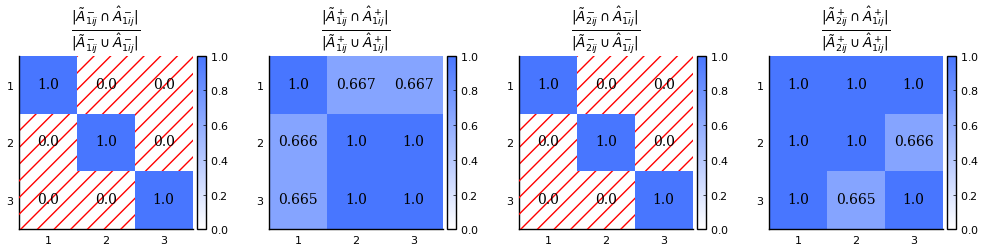

"非対角成分の算術平均: 0.0, 0.777, 0.0, 0.888"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[  2.85, \\left[   2.9,   3.1 \\right],  3.15 \\right] & \\left[ 8.122, \\left[ 8.828, 9.155 \\right], 9.923 \\right] \\\\ \\left[ 0.317, \\left[ 0.323, 0.345 \\right], 0.351 \\right] & \\le" ⋯ 34 bytes ⋯ "ght],   1.0 \\right] & \\left[  2.63, \\left[   2.9,   3.1 \\right], 3.414 \\right] \\\\ \\left[ 0.101, \\left[ 0.109, 0.113 \\right], 0.123 \\right] & \\left[ 0.293, \\left[ 0.323, 0.345 \\right],  0.38 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

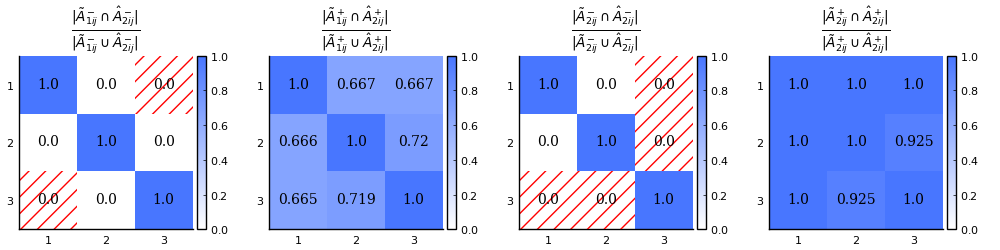

"非対角成分の算術平均: 0.0, 0.684, 0.0, 0.975"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   2.9, \\left[ 2.977, 3.001 \\right],   3.1 \\right] & \\left[ 9.246, \\left[ 9.302, 9.435 \\right],  9.61 \\right] \\\\ \\left[ 0.323, \\left[ 0.333, 0.336 \\right], 0.345 \\right] & \\le" ⋯ 34 bytes ⋯ "ght],   1.0 \\right] & \\left[ 3.001, \\left[   3.1, 3.209 \\right], 3.294 \\right] \\\\ \\left[ 0.104, \\left[ 0.106, 0.108 \\right], 0.108 \\right] & \\left[ 0.304, \\left[ 0.312, 0.323 \\right], 0.333 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

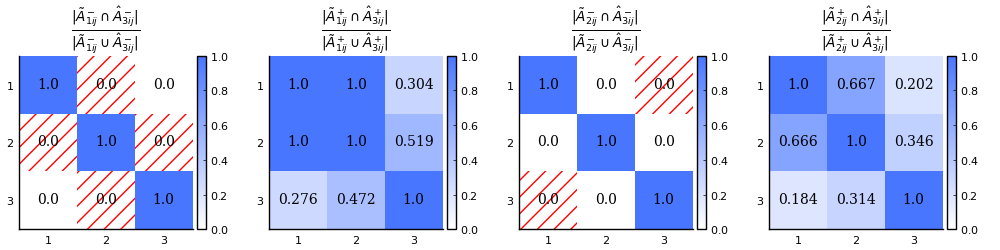

"非対角成分の算術平均: 0.0, 0.595, 0.0, 0.396"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

L"$\hat{A}_{4} = \begin{bmatrix} \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] & \left[  2.85, \emptyset,  3.15 \right] & \left[ 8.122, \emptyset, 9.923 \right] \\ \left[ 0.317, \emptyset, 0.351 \right] & \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] & \left[ 2.602, \emptyset,  3.45 \right] \\ \left[ 0.101, \emptyset, 0.123 \right] & \left[  0.29, \emptyset, 0.384 \right] & \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] \end{bmatrix}$"

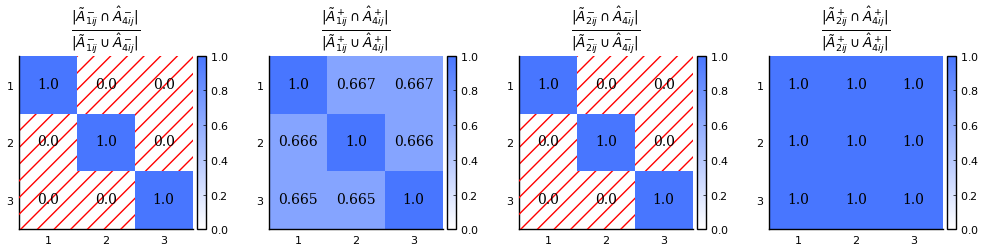

"非対角成分の算術平均: 0.0, 0.666, 0.0, 1.0"

In [12]:
# 1 3 9
# 1/3 1 3
# 1/9 1/3 1

A₁ = [
    1..1 2.9..3.1 2.9^2..3.1^2
    (1/3.1)..(1/2.9) 1..1 2.9..3.1
    (1/3.1)^2..(1/2.9)^2 (1/3.1)..(1/2.9) 1..1
]
A₂ = [
    1..1 2.85..3.15 2.85^2..3.15^2
    (1/3.15)..(1/2.85) 1..1 2.85..3.15
    (1/3.15)^2..(1/2.85)^2 (1/3.15)..(1/2.85) 1..1
]

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

Ã₁⁻, Ã₁⁺ = generateRevisedMatrix(A₁)
Ã₂⁻, Ã₂⁺ = generateRevisedMatrix(A₂)

Ã₁ = intervalPCM2TwofoldIntervalPCM(Ã₁⁻, Ã₁⁺)
display(L"\tilde{A}_1 = %$(twofoldIntervalMatrixLaTeXString(Ã₁))")
Ã₂ = intervalPCM2TwofoldIntervalPCM(Ã₂⁻, Ã₂⁺)
display(L"\tilde{A}_2 = %$(twofoldIntervalMatrixLaTeXString(Ã₂))")

plotAll(A₁, A₂)

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.937, 2.004 \right] & \left[ 3.881, 4.181 \right] \\ \left[ 0.499, 0.516 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.907, 2.079 \right] \\ \left[ 0.239, 0.258 \right] & \left[ 0.481, 0.524 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.949, 2.06 \right] & \left[ 3.826, 4.038 \right] \\ \left[ 0.486, 0.513 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.948, 2.039 \right] \\ \left[ 0.248, 0.261 \right] & \left[ 0.49, 0.513 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

"\$\\tilde{A}_1 = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.937, \\left[  1.96,  1.96 \\right], 2.018 \\right] & \\left[ 3.848, \\left[ 4.076, 4.076 \\right], 4.181 \\right] \\\\ \\left[ 0.496, \\left[  0.51,  0.51 \\right], 0.516 \\right] & \\le" ⋯ 34 bytes ⋯ "ght],   1.0 \\right] & \\left[ 1.907, \\left[ 2.079, 2.079 \\right], 2.159 \\right] \\\\ \\left[ 0.239, \\left[ 0.245, 0.245 \\right],  0.26 \\right] & \\left[ 0.463, \\left[ 0.481, 0.481 \\right], 0.524 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

"\$\\tilde{A}_2 = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.949, \\left[ 2.014, 2.014 \\right],  2.06 \\right] & \\left[ 3.826, \\left[ 4.038, 4.038 \\right], 4.038 \\right] \\\\ \\left[ 0.486, \\left[ 0.496, 0.496 \\right], 0.513 \\right] & \\le" ⋯ 34 bytes ⋯ "ght],   1.0 \\right] & \\left[ 1.878, \\left[ 2.005, 2.005 \\right], 2.049 \\right] \\\\ \\left[ 0.248, \\left[ 0.248, 0.248 \\right], 0.261 \\right] & \\left[ 0.488, \\left[ 0.499, 0.499 \\right], 0.532 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.937, \\left[ 1.955, 1.955 \\right],  2.06 \\right] & \\left[ 3.826, \\left[ 3.894, 3.894 \\right], 4.181 \\right] \\\\ \\left[ 0.486, \\left[ 0.511, 0.511 \\right], 0.516 \\right] & \\le" ⋯ 34 bytes ⋯ "ght],   1.0 \\right] & \\left[ 1.907, \\left[ 1.992, 1.992 \\right], 2.079 \\right] \\\\ \\left[ 0.239, \\left[ 0.257, 0.257 \\right], 0.261 \\right] & \\left[ 0.481, \\left[ 0.502, 0.502 \\right], 0.524 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

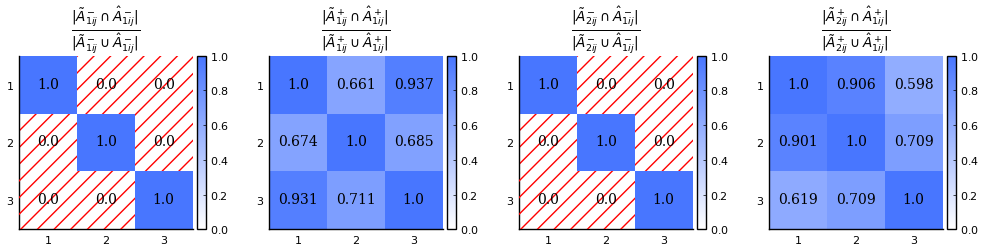

"非対角成分の算術平均: 0.0, 0.766, 0.0, 0.74"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.937, \\left[ 1.949, 2.004 \\right],  2.06 \\right] & \\left[ 3.826, \\left[ 3.881, 4.028 \\right], 4.181 \\right] \\\\ \\left[ 0.486, \\left[ 0.499, 0.513 \\right], 0.516 \\right] & \\le" ⋯ 34 bytes ⋯ "ght],   1.0 \\right] & \\left[   1.9, \\left[ 1.963, 2.039 \\right],  2.11 \\right] \\\\ \\left[ 0.239, \\left[ 0.248, 0.258 \\right], 0.261 \\right] & \\left[ 0.474, \\left[  0.49,  0.51 \\right], 0.526 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

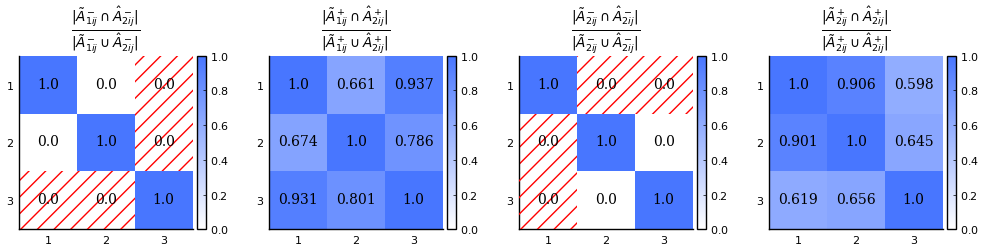

"非対角成分の算術平均: 0.0, 0.798, 0.0, 0.721"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[  1.96, \\left[  1.96, 2.001 \\right], 2.031 \\right] & \\left[ 4.012, \\left[ 4.012, 4.038 \\right], 4.103 \\right] \\\\ \\left[ 0.492, \\left[   0.5,  0.51 \\right],  0.51 \\right] & \\le" ⋯ 34 bytes ⋯ "ght],   1.0 \\right] & \\left[ 1.988, \\left[ 2.005, 2.047 \\right], 2.079 \\right] \\\\ \\left[ 0.244, \\left[ 0.248, 0.249 \\right], 0.249 \\right] & \\left[ 0.481, \\left[ 0.489, 0.499 \\right], 0.503 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

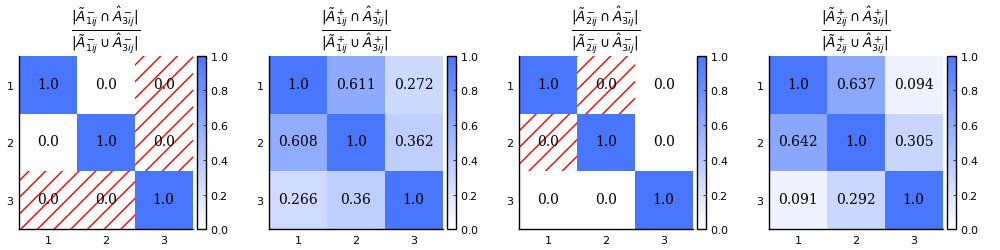

"非対角成分の算術平均: 0.0, 0.413, 0.0, 0.344"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

L"$\hat{A}_{4} = \begin{bmatrix} \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] & \left[ 1.937, \emptyset,  2.06 \right] & \left[ 3.826, \emptyset, 4.181 \right] \\ \left[ 0.486, \emptyset, 0.516 \right] & \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] & \left[ 1.878, \emptyset, 2.159 \right] \\ \left[ 0.239, \emptyset, 0.261 \right] & \left[ 0.463, \emptyset, 0.532 \right] & \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] \end{bmatrix}$"

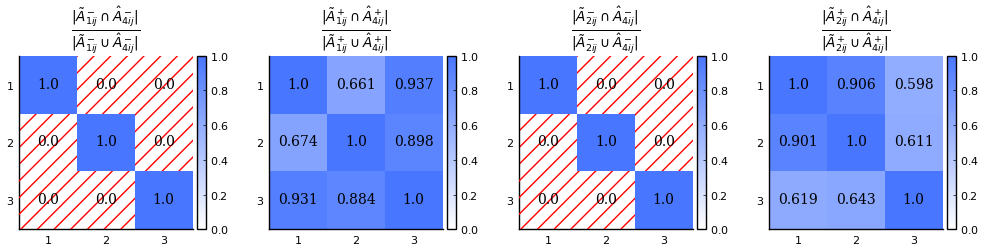

"非対角成分の算術平均: 0.0, 0.831, 0.0, 0.713"

In [10]:
A = [
    1 2 4
    1/2 1 2
    1/4 1/2 1
]

A₁ = randamizedIntervalPCM(A, 234)
A₂ = randamizedIntervalPCM(A, 123)

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

Ã₁⁻, Ã₁⁺ = generateRevisedMatrix(A₁)
Ã₂⁻, Ã₂⁺ = generateRevisedMatrix(A₂)

Ã₁ = intervalPCM2TwofoldIntervalPCM(Ã₁⁻, Ã₁⁺)
display(L"\tilde{A}_1 = %$(twofoldIntervalMatrixLaTeXString(Ã₁))")
Ã₂ = intervalPCM2TwofoldIntervalPCM(Ã₂⁻, Ã₂⁺)
display(L"\tilde{A}_2 = %$(twofoldIntervalMatrixLaTeXString(Ã₂))")

plotAll(A₁, A₂)